<h2>Fáza 1 - Prieskumná analýza</h2>
<p>Cieľom tejto fázy projektu je vykonať prieskumnú analýzu dát, ktorá nám umožní detailne preskúmať ich štruktúru, kvalitu a základné charakteristiky. Zameriame sa na opis dostupných atribútov, analýzu ich distribúcií a vzťahov, identifikáciu chýbajúcich alebo vychýlených hodnôt a overenie prvotných hypotéz o dátach. Výsledkom bude súhrnné zhodnotenie dát a pripravený podklad pre ďalšie spracovanie a budovanie predikčného modelu saturácie kyslíkom.</p>
<h4>1.1 Základný opis dát spolu s ich charakteristikami</h4>


In [2]:
# main imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams['font.family'] = 'DejaVu Sans'
observation = pd.read_csv("047/observation.csv", on_bad_lines='skip', sep="\t")
patient = pd.read_csv("047/patient.csv", on_bad_lines='skip', sep="\t")
station = pd.read_csv("047/station.csv", on_bad_lines='skip', sep="\t")

In [4]:
def overview(df, name):
    print(f"--- {name} ---")
    print("Shape (rows, columns):", df.shape)
    print("Columns and types:\n", df.dtypes)
    print("First 5 rows:\n", df.head())
    print("Missing values per column:\n", df.isna().sum())
    print("\n")

overview(observation, "Observation")
overview(patient, "Patient")
overview(station, "Station")

--- Observation ---
Shape (rows, columns): (12140, 23)
Columns and types:
 SpO₂                     float64
HR                       float64
PI                       float64
RR                       float64
EtCO₂                    float64
FiO₂                     float64
PRV                      float64
BP                       float64
Skin Temperature         float64
Motion/Activity index    float64
PVI                      float64
Hb level                 float64
SV                       float64
CO                       float64
Blood Flow Index         float64
PPG waveform features    float64
Signal Quality Index     float64
Respiratory effort       float64
O₂ extraction ratio      float64
SNR                      float64
oximetry                 float64
latitude                 float64
longitude                float64
dtype: object
First 5 rows:
         SpO₂         HR         PI         RR      EtCO₂       FiO₂  \
0  98.133718  78.731183   9.000522  18.150739  42.023169  54.10263

<p>Pri prvej kontrole dát sme analyzovali štruktúru a základné charakteristiky troch datasetov: Observation, Patient a Station.

Dataset Observation obsahuje 12 140 záznamov a 23 atribútov, ktoré predstavujú rôzne fyziologické signály a senzorové hodnoty vrátane cieľovej premennej oximetry. Všetky stĺpce sú typu float64 a v dátach sa nevyskytujú žiadne chýbajúce hodnoty, čo zjednodušuje ich ďalšie spracovanie.

Dataset Patient obsahuje 2 161 záznamov a 13 atribútov opisujúcich informácie o pacientoch vrátane identifikátorov, kontaktných údajov a priradenia ku konkrétnej stanici. Niektoré stĺpce, ako napr. current_location, residence a job, obsahujú chýbajúce hodnoty, ktoré bude potrebné riešiť pri čistení dát.

Dataset Station pozostáva zo 739 záznamov a 6 atribútov, ktoré obsahujú geografickú polohu staníc, ich kód, názov, kvalitu služby (QoS) a revíziu. V tomto datasete sa nevyskytujú žiadne chýbajúce hodnoty.

Z analýzy vyplýva, že Observation je dobre pripravený na ďalšie spracovanie, zatiaľ čo Patient bude vyžadovať doplnenie alebo úpravu chýbajúcich hodnôt. Dataset Station je kompletne vyplnený a pripravený na prípadné spojenie s ostatnými datasetmi podľa atribútu station_ID či geografickej polohy.
</p>

<h4>1.2 Analýza jednotlivých atribútov</h4>
<p>Vyberieme si tieto atribúty: SpO₂ (oxygen saturation), HR (heart rate), RR (respiratory rate), BP (blood pressure), Skin Temperature, FiO₂ (fraction of inspired oxygen), Hb level (hemoglobin), CO (cardiac output), SV (stroke volume), oximetry (target variable).</p>

                    count        mean        std   min         25%  \
SpO₂              12140.0   97.676983   0.858321  95.0   96.996253   
HR                12140.0   81.667112   6.557040  60.0   76.512396   
RR                12140.0   16.248185   1.040213  12.0   15.584806   
BP                12140.0  105.866093   4.869691  90.0  102.231195   
Skin Temperature  12140.0   35.388953   0.691888  33.0   34.870687   
FiO₂              12140.0   59.031784  10.761312  21.0   51.788058   
Hb level          12140.0   15.254823   0.727130  12.0   14.768655   
CO                12140.0    4.021514   0.093351   4.0    4.000109   
SV                12140.0   87.974337   2.939555  60.0   86.049867   
oximetry          12140.0    0.596293   0.490660   0.0    0.000000   

                         50%         75%    max  
SpO₂               97.811612   98.368528  100.0  
HR                 80.677561   87.543288  100.0  
RR                 16.257046   16.930834   20.0  
BP                106.148010 

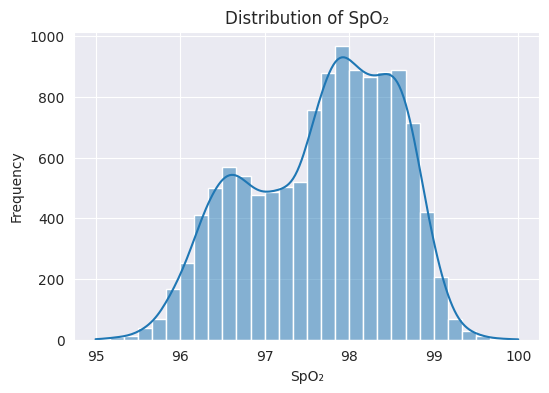

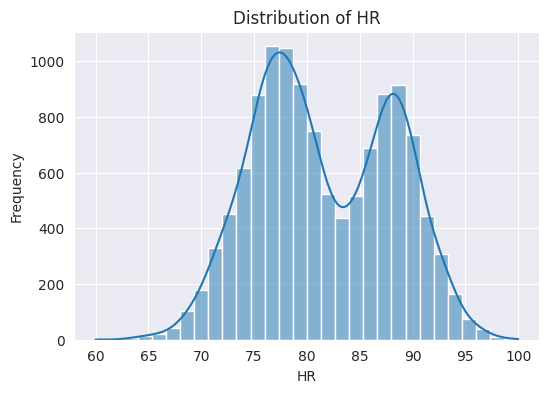

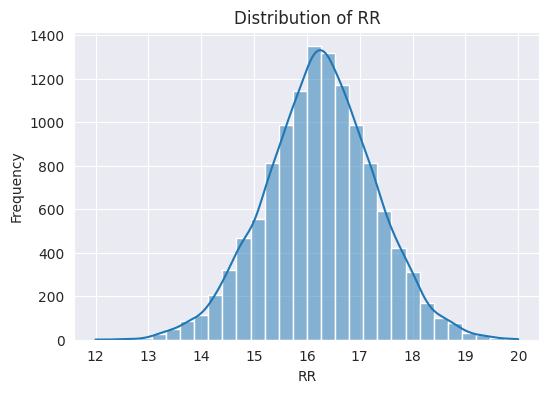

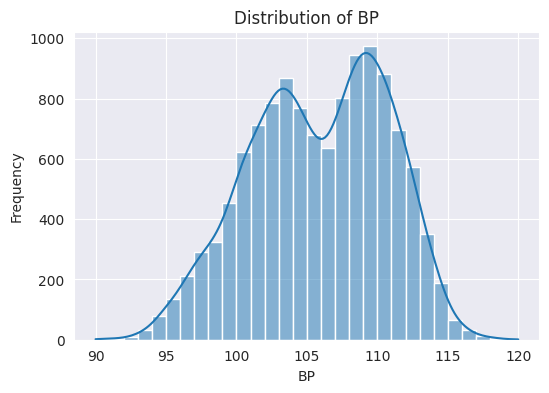

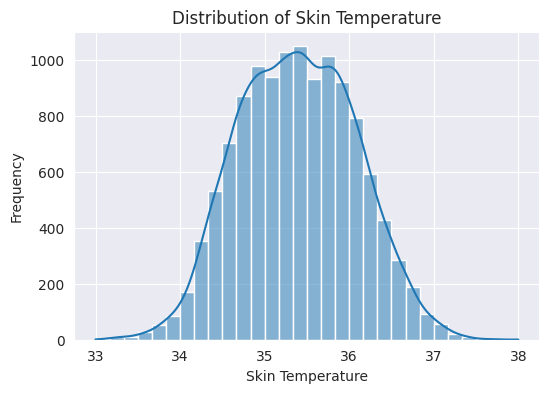

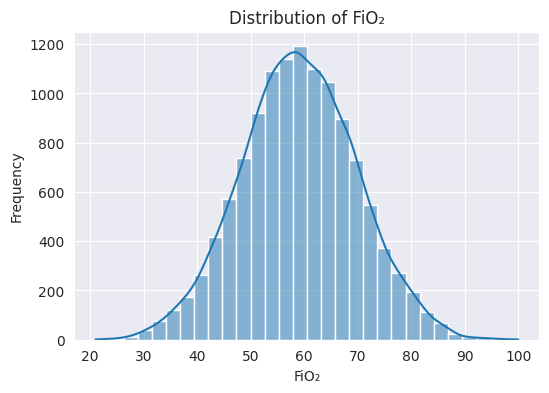

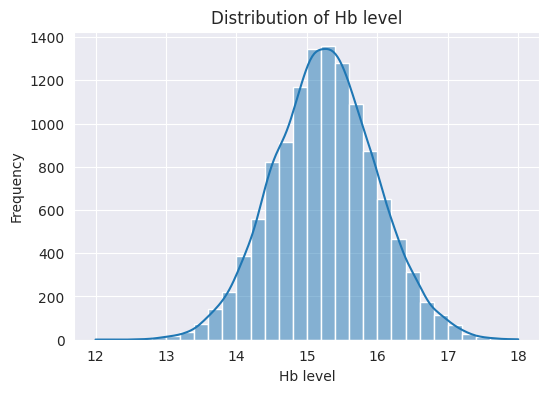

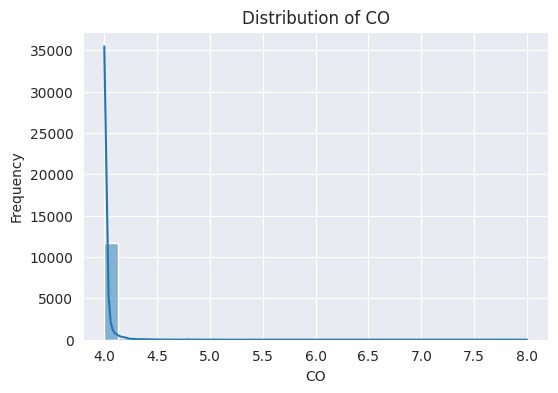

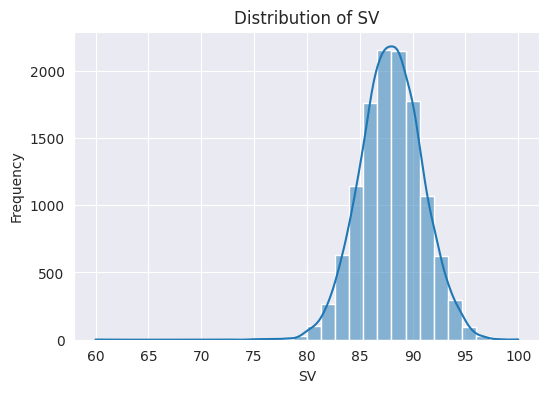

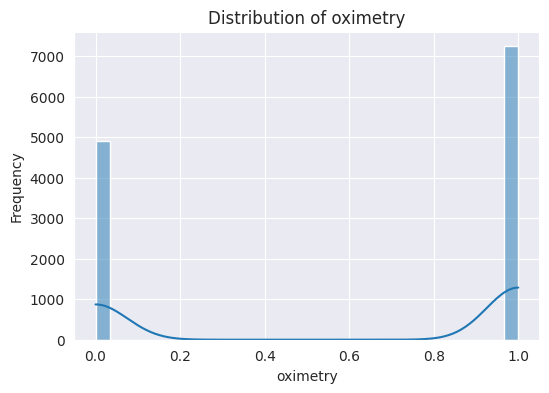

In [5]:
attributes = [
    "SpO₂", "HR", "RR", "BP", "Skin Temperature",
    "FiO₂", "Hb level", "CO", "SV", "oximetry"
]

desc_stats = observation[attributes].describe().T
print(desc_stats)

for col in attributes:
    plt.figure(figsize=(6,4))
    sns.histplot(observation[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

<p>Pre vybrané atribúty sme analyzovali ich distribúcie a základné deskriptívne štatistiky. Väčšina hodnôt sa nachádza v očakávaných fyziologických intervaloch, avšak v niektorých prípadoch sa vyskytujú zvláštne hodnoty: Heart rate nemá normálne rozloženie, Oximetry má tiež zaujímavé rozdelenie. Budú zrejme vyžadovať ďalšie spracovanie v rámci čistenia dát.</p>

##### C - Párová analýza dát: vzťahy a závislostí medzi dvojicami atribútov

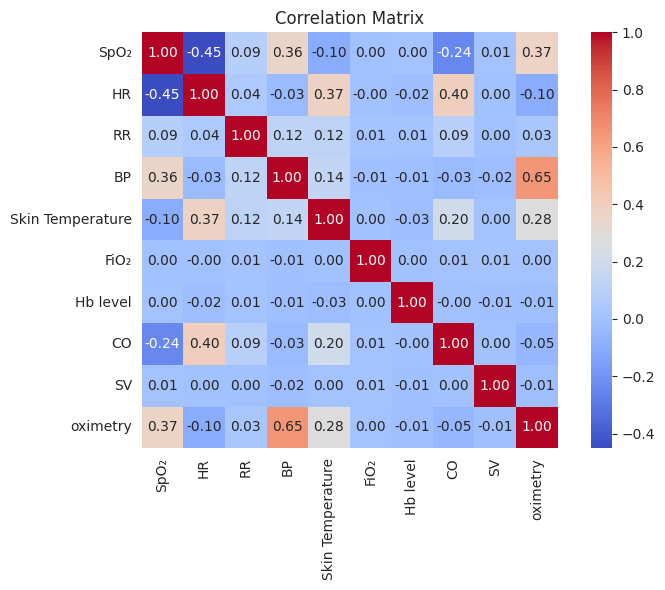

In [6]:
corr_matrix = observation[attributes].corr()


plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


##### D - Párová analýza dát: závislosti medzi predikovanou premennou a ostatnými premennými


Correlation between target and predictors:
BP                  0.654
SpO₂                0.368
Skin Temperature    0.276
HR                  0.102
CO                  0.050
RR                  0.031
Hb level            0.012
SV                  0.011
FiO₂                0.004
Name: oximetry, dtype: float64


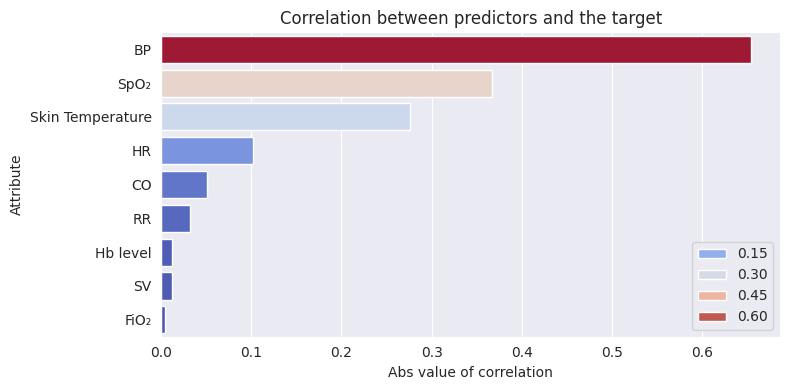

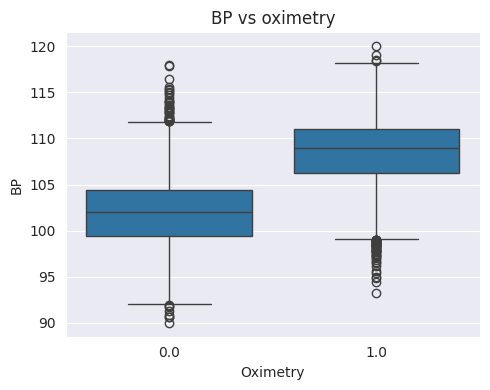

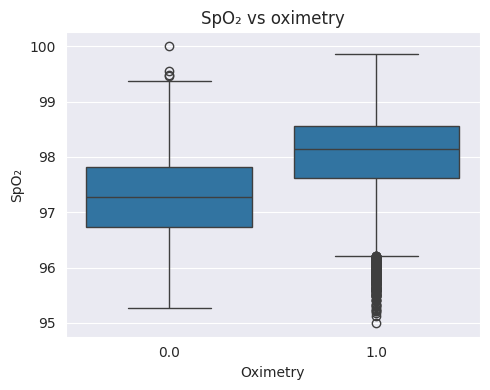

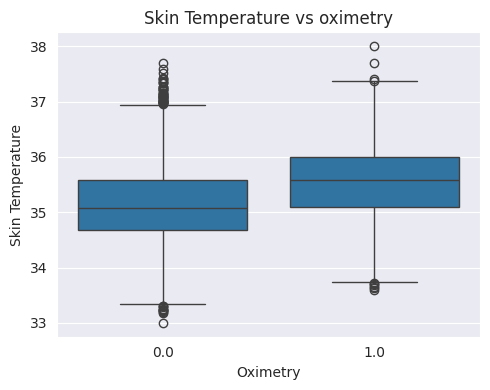

In [12]:
target = "oximetry"

predictors = [
    "SpO₂", "HR", "RR", "BP", "Skin Temperature",
    "FiO₂", "Hb level", "CO", "SV"
]

correlations = observation[predictors + [target]].corr()[target].drop(target)

correlations_sorted = correlations.abs().sort_values(ascending=False)

print("Correlation between target and predictors:")
print(correlations_sorted.round(3))


plt.figure(figsize=(8,4))
sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, hue=correlations_sorted.values,palette="coolwarm")
plt.title("Correlation between predictors and the target")
plt.xlabel("Abs value of correlation")
plt.ylabel("Attribute")
plt.tight_layout()
plt.show()

top3 = correlations_sorted.head(3).index
for col in top3:
    plt.figure(figsize=(5,4))
    sns.boxplot(data=observation, x="oximetry", y=col)
    plt.title(f"{col} vs oximetry")
    plt.xlabel("Oximetry")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


Doterajšia analýza ukázala, že premenná oximetry najviac koreluje s krvným tlakom (BP) a saturáciou kyslíkom (SpO₂). Ostatné atribúty majú len slabý vzťah. Preto bude vhodné kombinovať údaje zo všetkých troch súborov a pri modelovaní využiť viacero atribútov naraz, keďže žiadna jednotlivá premenná nevysvetľuje správanie cieľovej veličiny úplne.